In [1]:
#| include: false
import os

from sklearn.utils import shuffle, validation
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=0'

# Importación de las librerías necesarias

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
# ------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# ------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ------------------------------
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
## Cargar los datos

In [3]:
#| include: false
import kagglehub
import os
import shutil

target_dir = "kaggle/input"

if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

    shutil.move(path, target_dir)

In [4]:
def train_df(tr_path):
    classes, class_path = [], []
    for label in os.listdir(tr_path):
        label_path = os.path.join(tr_path, label)
        if os.path.isdir(label_path):
            images = os.listdir(label_path)
            for image in images:
                classes.append(label)
                class_path.append(os.path.join(label_path, image))

    tr_df = pd.DataFrame({'Class Path': class_path, 'Class': classes})
    return tr_df

In [5]:
def test_df(tr_path):
    classes, class_path = [], []
    for label in os.listdir(tr_path):
        label_path = os.path.join(tr_path, label)
        if os.path.isdir(label_path):
            images = os.listdir(label_path)
            # sampled_images = random.sample(images, min(limit, len(images))) Selección aleatoria
            for image in images:
                classes.append(label)
                class_path.append(os.path.join(label_path, image))

    ts_df = pd.DataFrame({'Class Path': class_path, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('kaggle/input/brain-tumor-mri-dataset/Training')

tr_df

,Class Path,Class
0,kaggle/input/brain-tumor-mri-dataset/Training/...,meningioma
1,kaggle/input/brain-tumor-mri-dataset/Training/...,meningioma
2,kaggle/input/brain-tumor-mri-dataset/Training/...,meningioma
3,kaggle/input/brain-tumor-mri-dataset/Training/...,meningioma
4,kaggle/input/brain-tumor-mri-dataset/Training/...,meningioma
...,...,...
5707,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
5708,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
5709,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
5710,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor


In [7]:
ts_df = test_df('kaggle/input/brain-tumor-mri-dataset/Testing')

ts_df

,Class Path,Class
0,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
1,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
2,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
3,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
4,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
...,...,...
1306,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
1307,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
1308,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
1309,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor


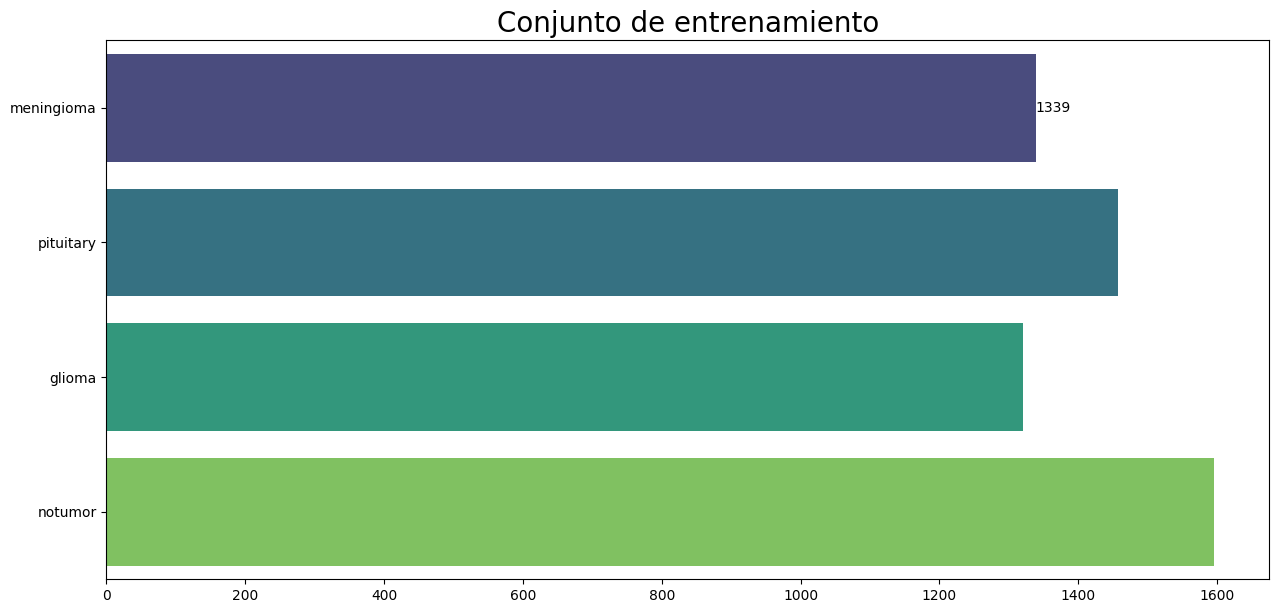

In [8]:
# Contamos las imágenes en cada clase de los datos de entrenamiento
plt.figure(figsize=(15, 7))

ax = sns.countplot(data=tr_df, y=tr_df['Class'], palette='viridis')
plt.xlabel('')
plt.ylabel('')
plt.title("Conjunto de entrenamiento", fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

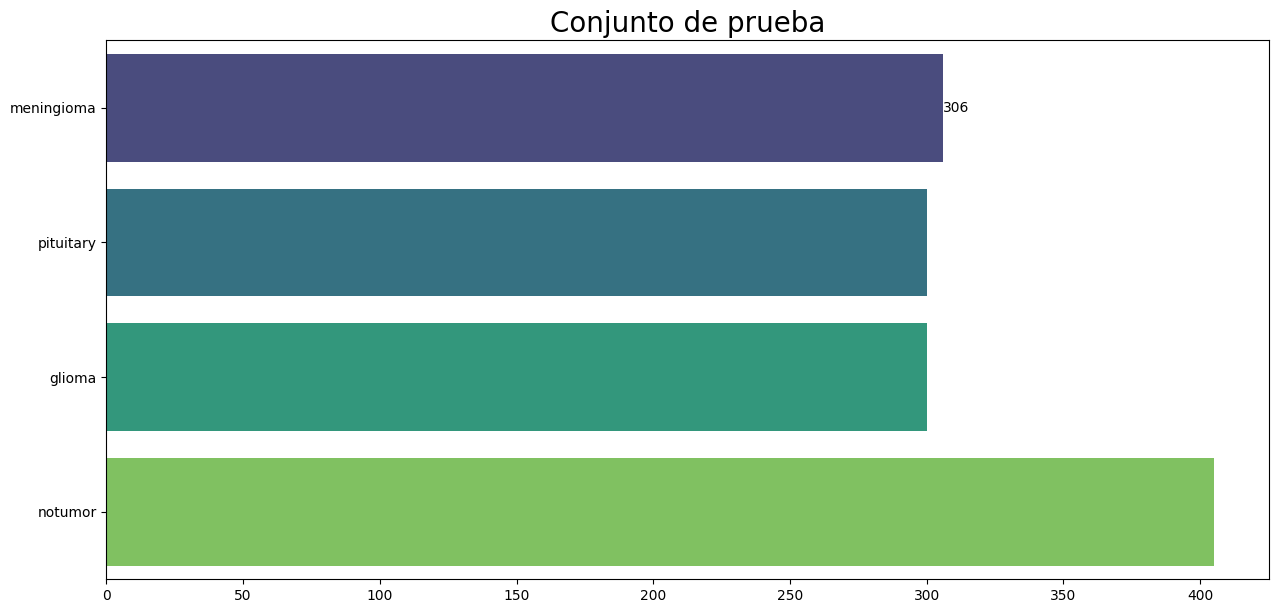

In [9]:
# Contamos las imágenes en cada clase de los datos de test
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='')
ax.bar_label(ax.containers[0])
plt.title('Conjunto de prueba', fontsize=20)
plt.show()

## División de los datos

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

valid_df

,Class Path,Class
892,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
18,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
367,kaggle/input/brain-tumor-mri-dataset/Testing/p...,pituitary
73,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
715,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
...,...,...
665,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
1160,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
879,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
194,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma


## Preprocesamiento de los datos

In [11]:
batch_size = 8
img_size = (150, 150)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode='categorical')

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=16,
                                     target_size=img_size, class_mode='categorical')

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', batch_size=16,
                                    target_size=img_size, class_mode='categorical',
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Mostramos ejemplos de los datos

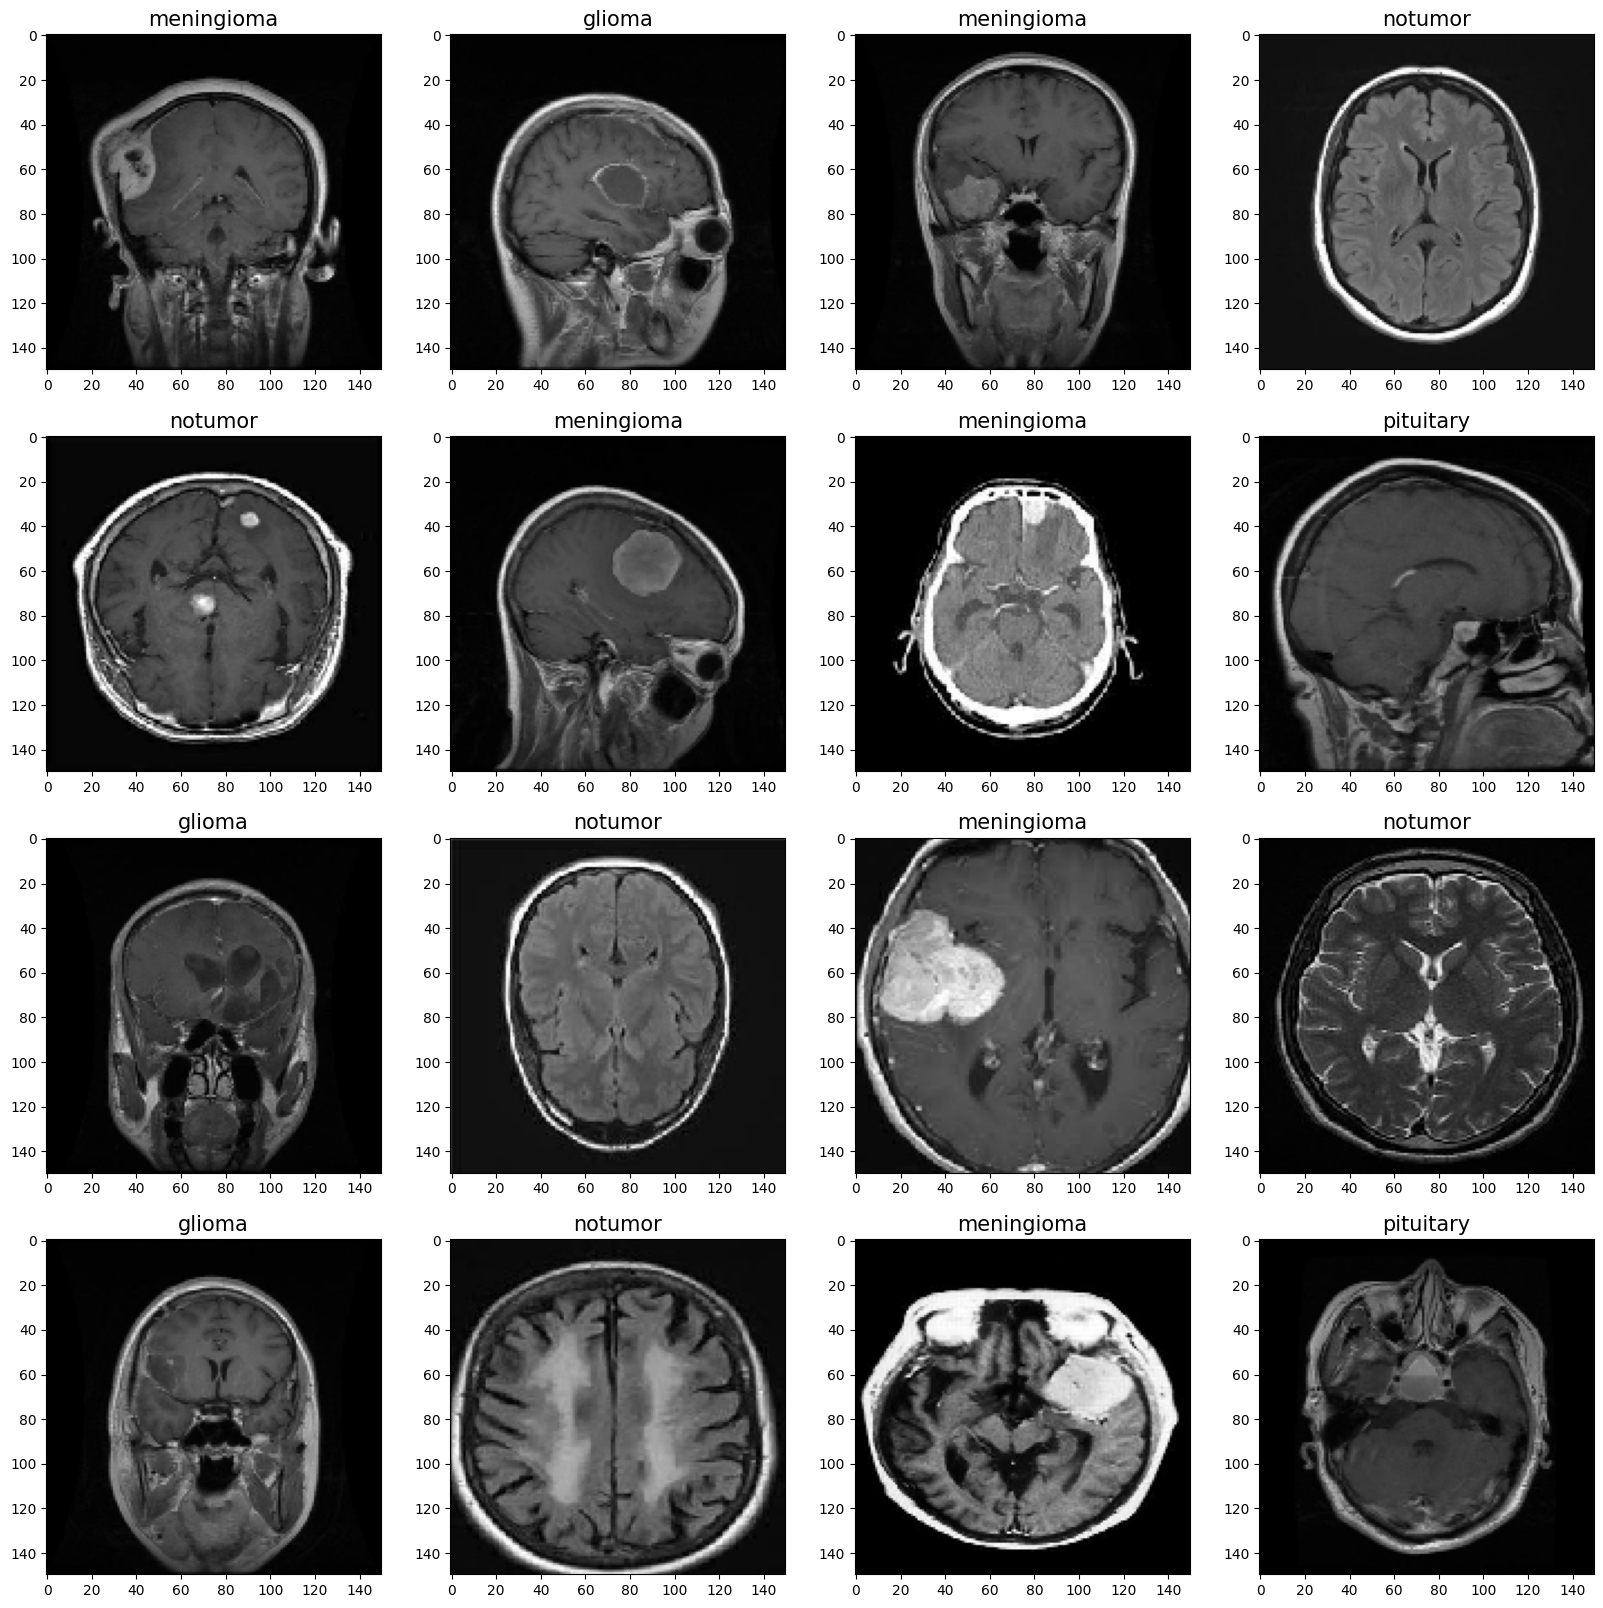

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))

for i, (image, label) in enumerate(zip(images, labels)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  class_name = classes[np.argmax(label)]
  plt.title(class_name, color='k', fontsize=15)

plt.show()

## Construimos el modelo de Deep Learning

In [13]:
img_shape=(150, 150, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                            input_shape=img_shape, pooling='max')

model = Sequential([
  base_model,
  Flatten(),
  Dropout(rate=0.3),
  Dense(128, activation='relu'),
  Dropout(rate=0.25),
  Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       Precision(),
                       Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

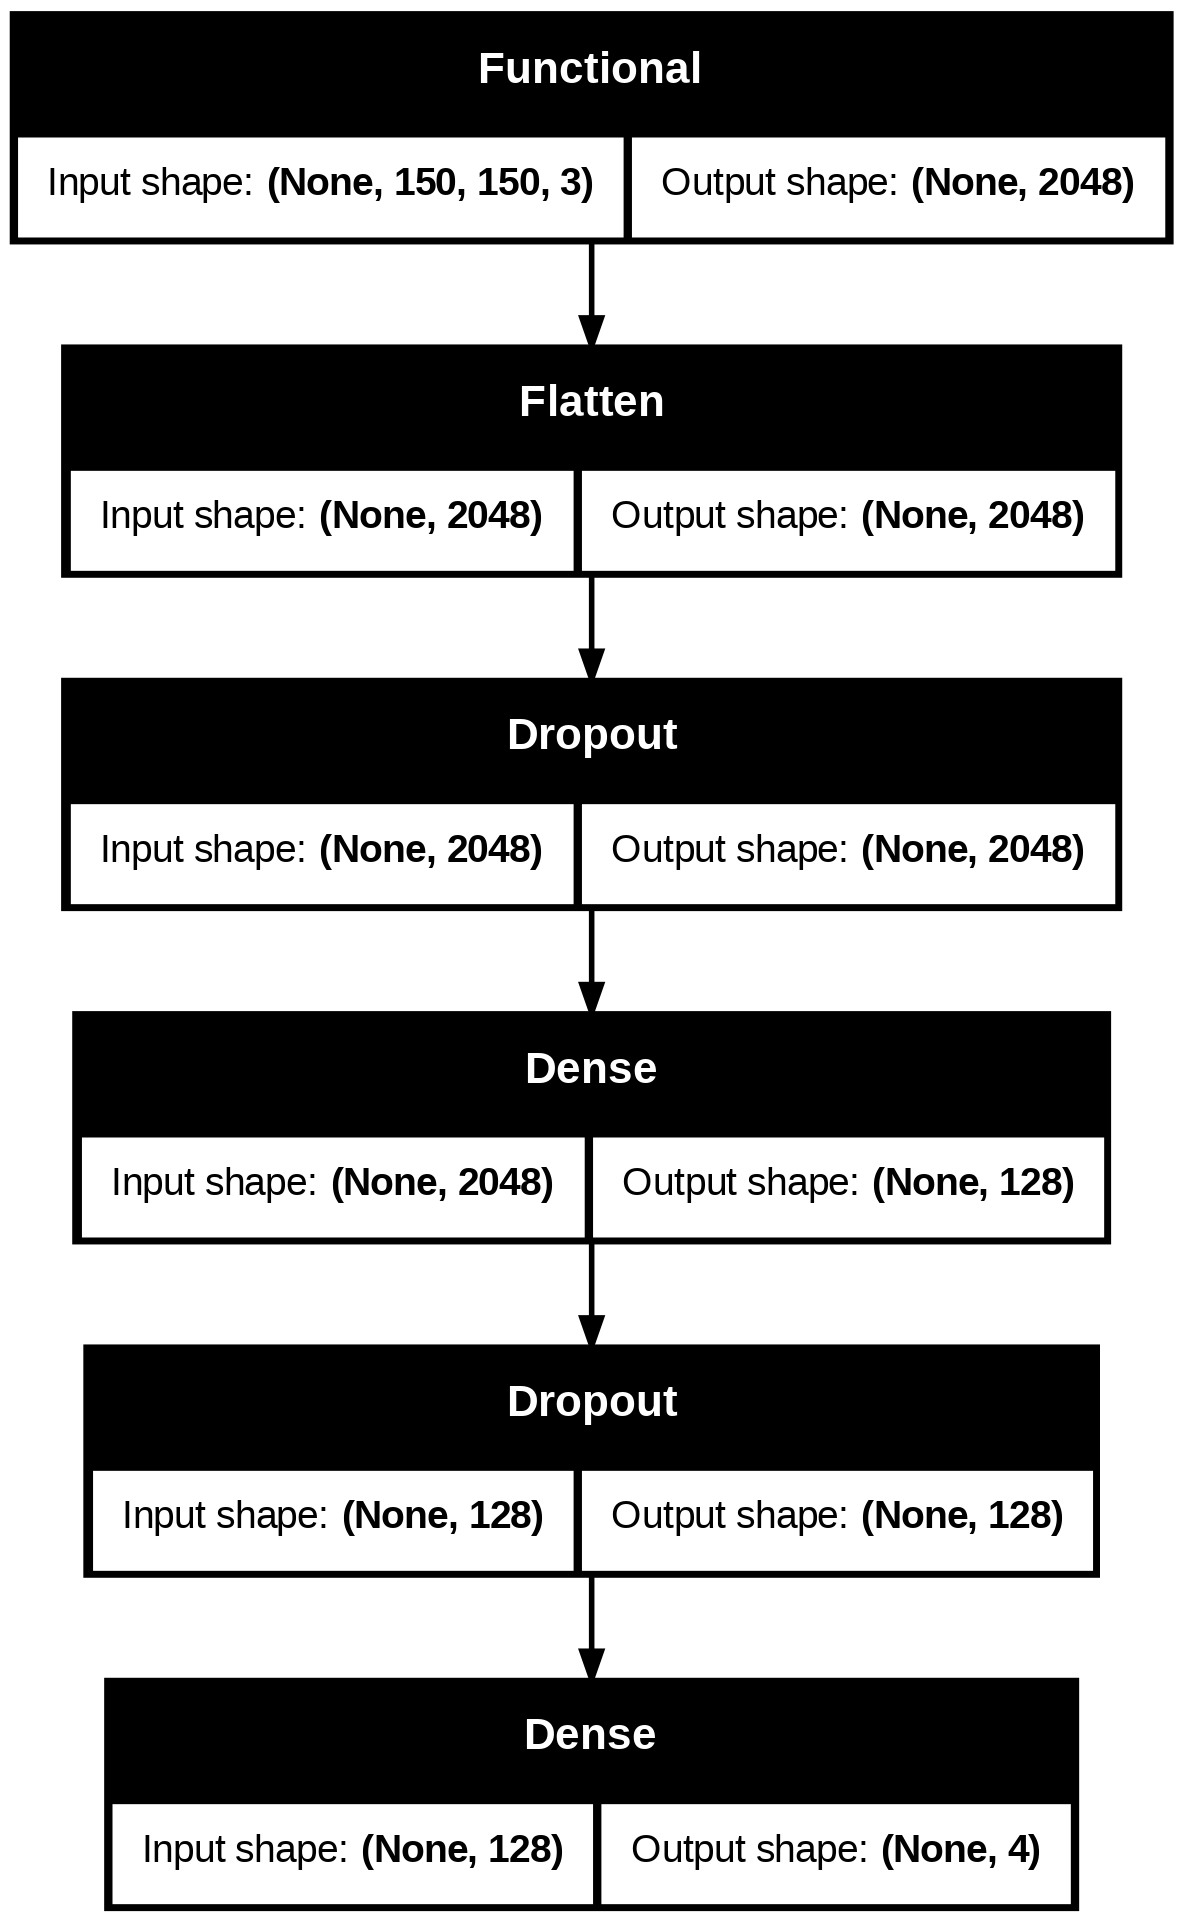

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Entrenamiento

In [15]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle=False)

hist.history.keys()

Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - accuracy: 0.7507 - loss: 0.6841 - precision: 0.8188 - recall: 0.6484 - val_accuracy: 0.9267 - val_loss: 0.2127 - val_precision: 0.9447 - val_recall: 0.9130
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.9365 - loss: 0.1798 - precision: 0.9454 - recall: 0.9293 - val_accuracy: 0.9740 - val_loss: 0.1118 - val_precision: 0.9755 - val_recall: 0.9710
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9693 - loss: 0.0850 - precision: 0.9708 - recall: 0.9680 - val_accuracy: 0.9878 - val_loss: 0.0448 - val_precision: 0.9878 - val_recall: 0.9863
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9844 - loss: 0.0471 - precision: 0.9849 - recall: 0.9827 - val_accuracy: 0.9893 - val_loss: 0.0799 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9916 - loss: 0.0346 - precision: 0.9920 - recall: 0.9912 - val_accuracy: 0.9817 - va

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

## Visualizamos el rendimiento del modelo

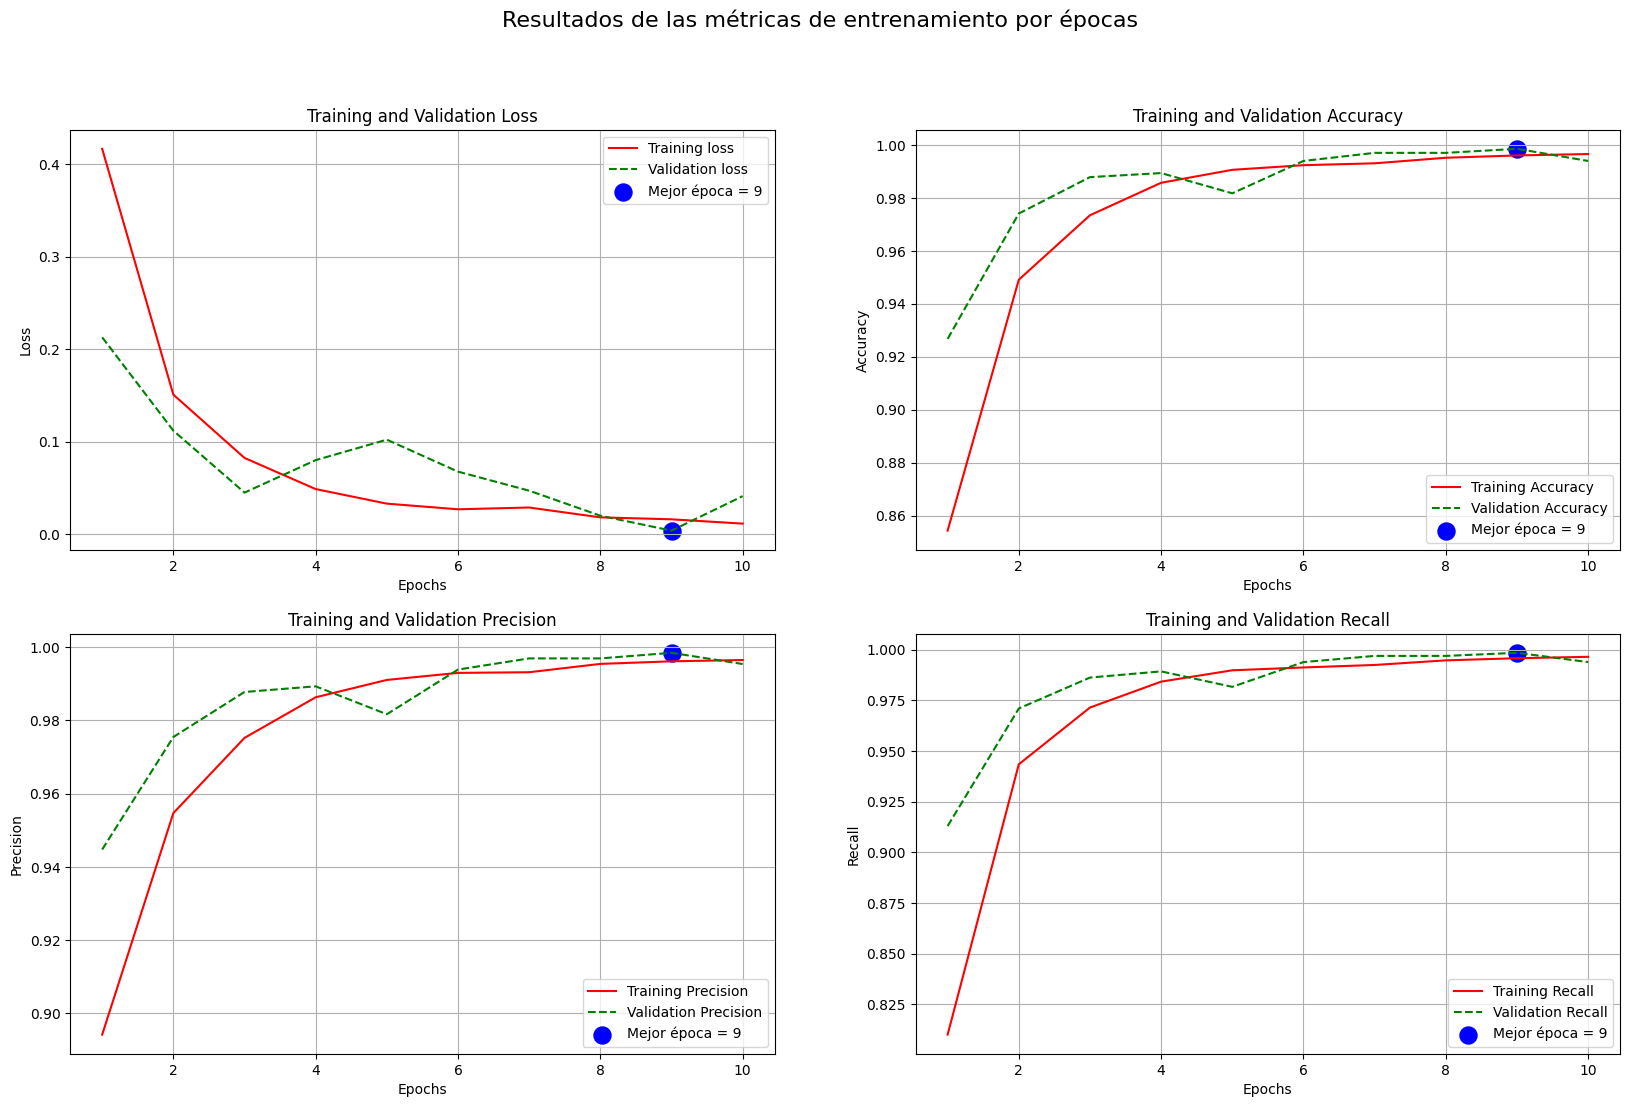

In [16]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f"Mejor época = {str(index_loss + 1)}"
acc_label = f"Mejor época = {str(index_acc + 1)}"
per_label = f"Mejor época = {str(index_precision + 1)}"
recall_label = f"Mejor época = {str(index_recall + 1)}"

plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g--', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g--', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Training Precision')
plt.plot(Epochs, val_per, 'g--', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g--', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Resultados de las métricas de entrenamiento por épocas', fontsize=16)
plt.show()

# Testing y Evaluación
## Evaluación

In [17]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train loss: {train_score[0]:.4f}")
print(f"Train accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation loss: {valid_score[0]:.4f}")
print(f"Validation accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test loss: {test_score[0]:.4f}")
print(f"Test accuracy: {test_score[1]*100:.2f}%")

714/714 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9976 - loss: 0.0290 - precision: 0.9980 - recall: 0.9976
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9947 - loss: 0.0328 - precision: 0.9947 - recall: 0.9932
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9762 - loss: 0.2822 - precision: 0.9762 - recall: 0.9753
Train loss: 0.0182
Train accuracy: 99.81%
--------------------
Validation loss: 0.0364
Validation accuracy: 99.54%
--------------------
Test loss: 0.1466
Test accuracy: 98.63%


In [18]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


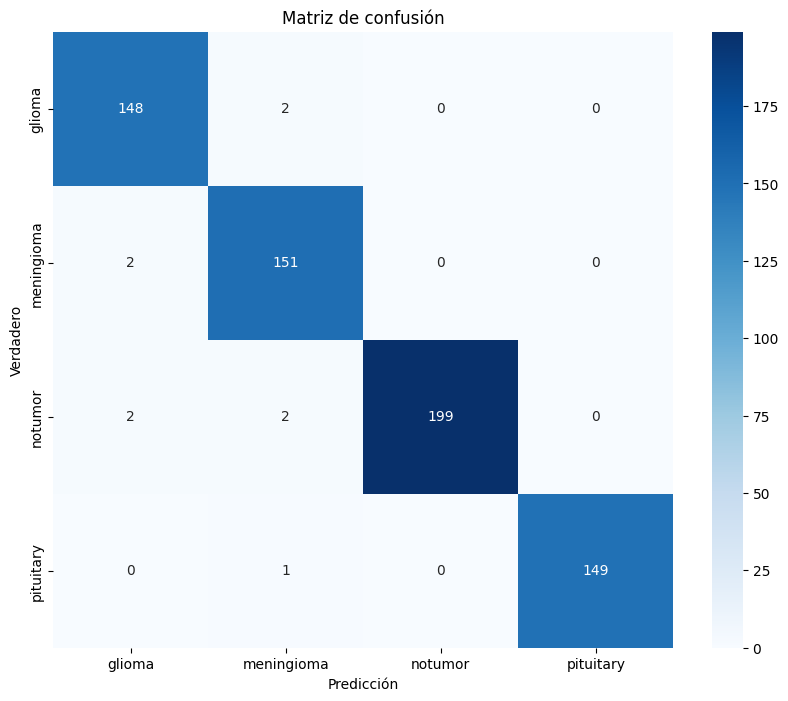

In [19]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.show()

In [20]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       0.97      0.99      0.98       153
           2       1.00      0.98      0.99       203
           3       1.00      0.99      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



## Testing

In [21]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path).convert('RGB')
    resized_img = img.resize((150, 150))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


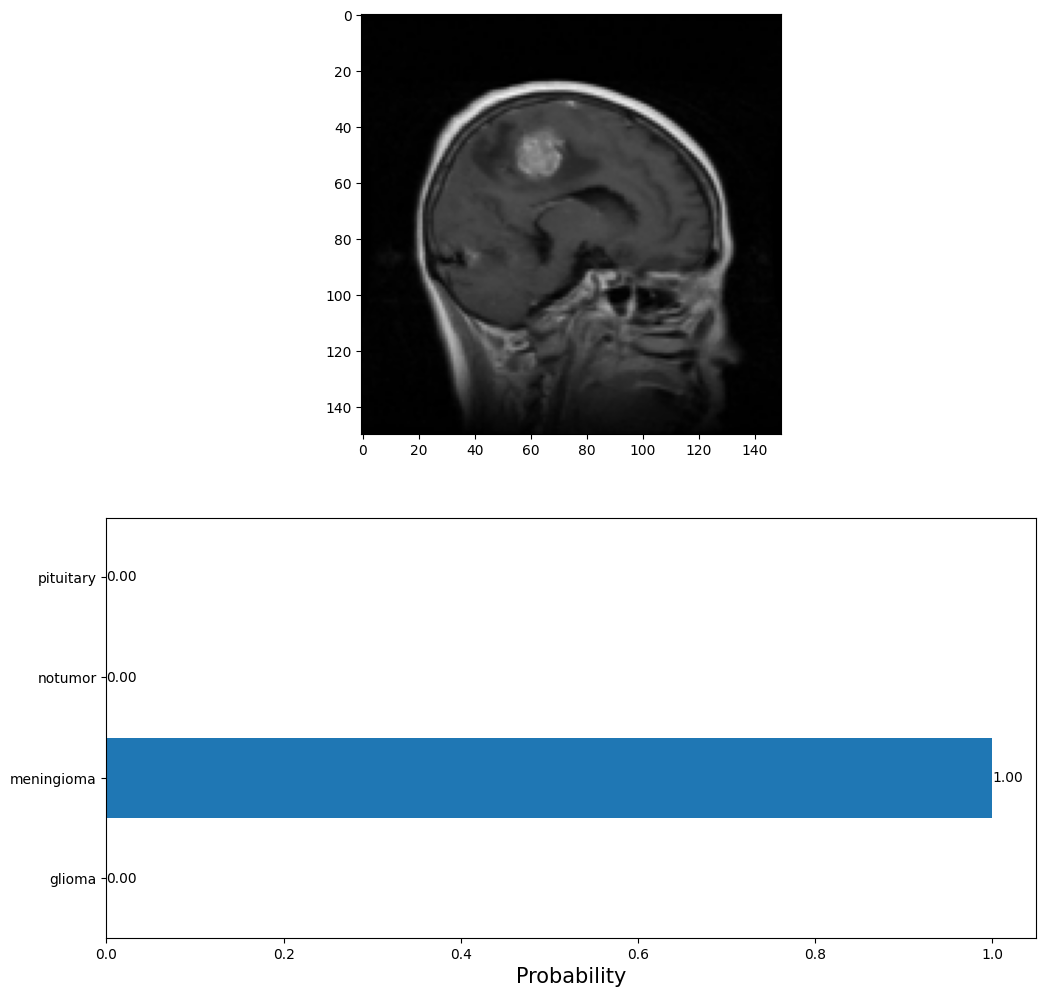

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


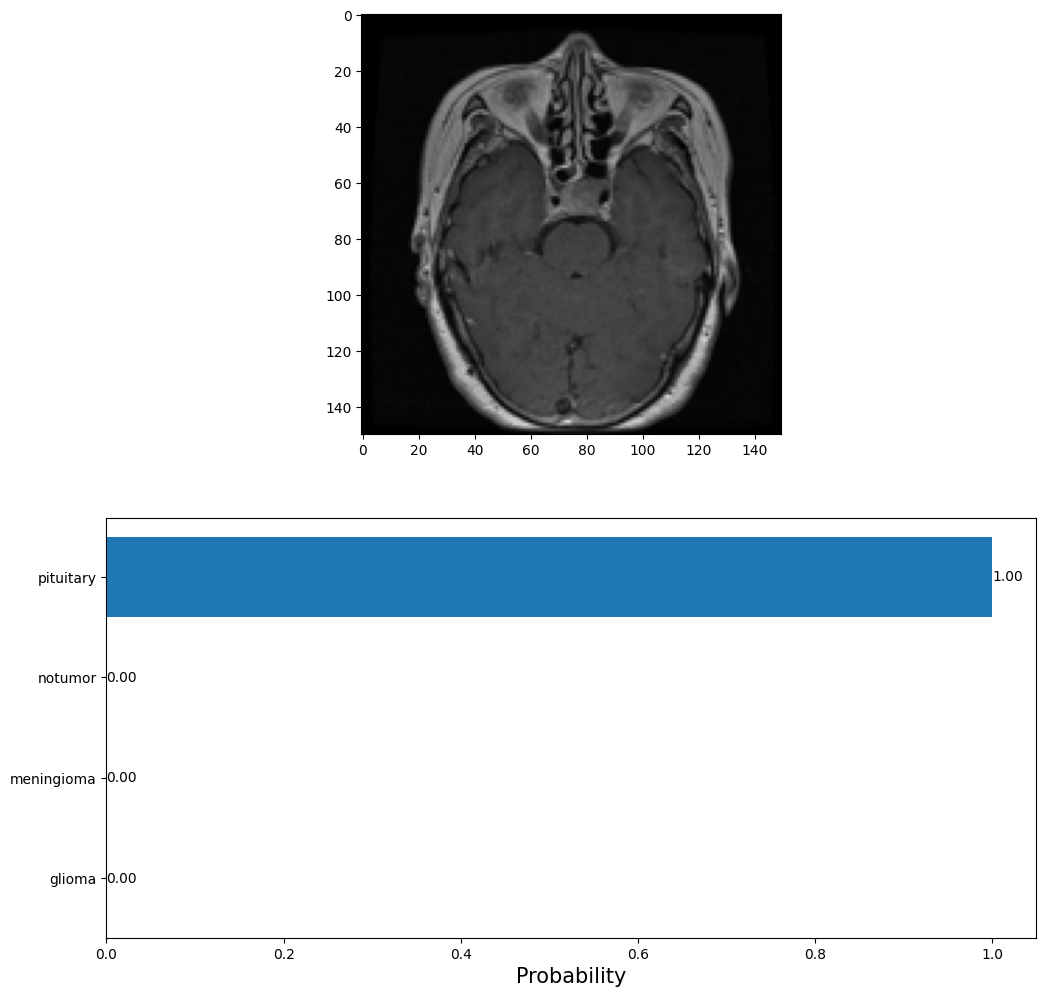

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


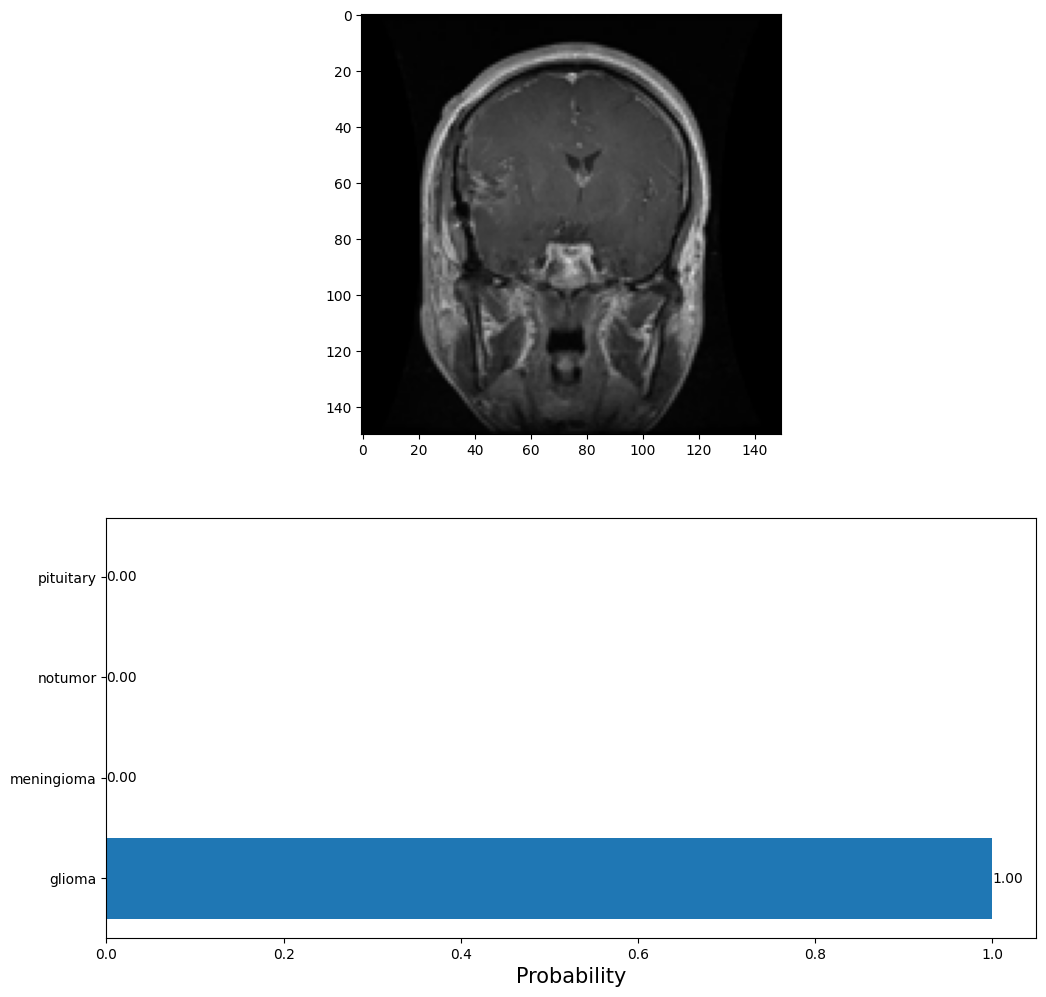

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


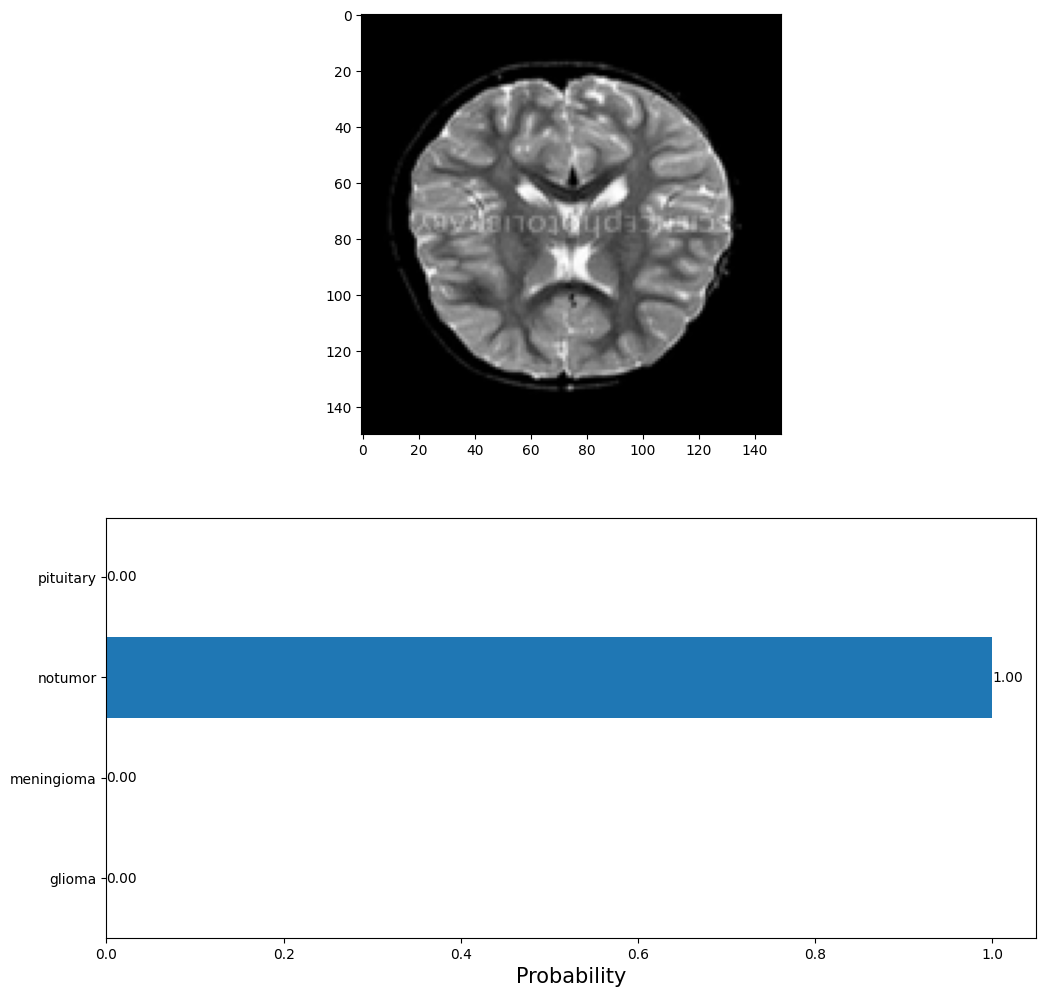

In [23]:
# Directorio base de las imágenes de prueba
test_dir = 'kaggle/input/brain-tumor-mri-dataset/Testing'

# Obtener una lista de todas las subcarpetas (clases)
class_folders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]

# Seleccionar 5 imágenes aleatorias de diferentes clases
random_images = []
for folder in class_folders:
    # Obtener una lista de todas las imágenes en la subcarpeta
    images = [f for f in os.listdir(os.path.join(test_dir, folder)) if os.path.isfile(os.path.join(test_dir, folder, f))]
    # Seleccionar una imagen aleatoria de la subcarpeta
    random_image = random.choice(images)
    random_images.append(os.path.join(test_dir, folder, random_image))

# Limitar la lista a 5 imágenes
random_images = random_images[:20]

# Mostrar las imágenes y sus predicciones
for image_path in random_images:
    predict(image_path)